<a href="https://colab.research.google.com/github/danielluca00/ML_Bone_fracture_detection/blob/main/bone_fracture_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# unzipping the input file
!unzip input.zip

Streaming output truncated to the last 5000 lines.
  inflating: input/train/labels/image1_299_png.rf.dd0cd19f150bc0af97f03e9315027f19.txt  
  inflating: input/train/labels/image1_408_png.rf.bcc08a0ecfc63e19cab787c1fcd4c084.txt  
  inflating: input/train/labels/image1_41_png.rf.c0d4cbcf250f634456863e855512d330.txt  
  inflating: input/train/labels/image1_2791_png.rf.b60a96e400bbe9f71ab5041655551b1b.txt  
  inflating: input/train/labels/image1_2752_png.rf.af6e69b719e9c33cb929323acb2d44af.txt  
 extracting: input/train/labels/image1_468_png.rf.fdd704088a2ef94b9489533d5e3ef074.txt  
  inflating: input/train/labels/image2_1127_png.rf.b0536d1c2039c884f67562c5246f9dbc.txt  
  inflating: input/train/labels/image1_750_png.rf.5876ef7ddbbb27f03ddf9a33f10db3b4.txt  
  inflating: input/train/labels/image1_3760_png.rf.797eb00f419ab0c1ccdd910ca9ca688b.txt  
  inflating: input/train/labels/image1_1022_png.rf.790daac7868bb104a1c5fd3642bcb389.txt  
 extracting: input/train/labels/image1_1234_png.rf.d331

In [ ]:
# cloning detectron2
import sys, os, distutils.core
!python -m pip install pyyaml==5.1
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 8.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 15837 (delta 35), reused 14 (delta 14), pack-reused 15772 (from 2)
Receiving objects: 100% (15837/15837), 6.41 MiB | 13.45 MiB/s, done.
Resolving deltas: 100% (11533/11533), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your e

In [ ]:
# importing dependencies
import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
print("detectron2 version:", detectron2.__version__)

import numpy as np
import os, json, cv2, random
import PIL
import matplotlib.pyplot as plt

#importing detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

SEED = 9
THRESHOLD = 0.3

detectron2 version: 0.6


In [ ]:
# creating coco instances
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode

for d in ["train", "valid", "test"]:
    register_coco_instances(f"bone_fractures_{d}", {},
                            f"input/{d}_annotations.coco.json",
                            f"input/{d}/images")

In [ ]:
# import kagglehub

# kagglehub.dataset_download('banddaniel/bone-fracture-detection-detection-coco-annots')
# kagglehub.dataset_download('pkdarabi/bone-fracture-detection-computer-vision-project')


100%|██████████| 259k/259k [00:00<00:00, 76.4MB/s]

Extracting files...


100%|██████████| 84.1M/84.1M [00:00<00:00, 112MB/s]

Extracting files...


In [ ]:
# examples from the training dataset

import random
from detectron2.utils.visualizer import Visualizer

my_dataset_train_metadata = MetadataCatalog.get("bone_fractures_train")
train_dataset_dicts = DatasetCatalog.get("bone_fractures_train")

def create_random_images(dataset_dict,dataset_metadata, seed, image_scale = 0.7):
    np.random.seed(seed)
    images = np.random.permutation(dataset_dict)[:2]

    fig, axs = plt.subplots(1,2, figsize = (12,6), dpi = 100)
    for i in range(2):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        vis = visualizer.draw_dataset_dict(im)
        final_img = vis.get_image()

        axs[i].set_title('image id: ' + str(img_id), fontsize = 10)
        axs[i].axis('off')
        axs[i].imshow(final_img)

WARNING [03/01 11:09:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/01 11:09:23 d2.data.datasets.coco]: Loaded 3631 images in COCO format from input/train_annotations.coco.json


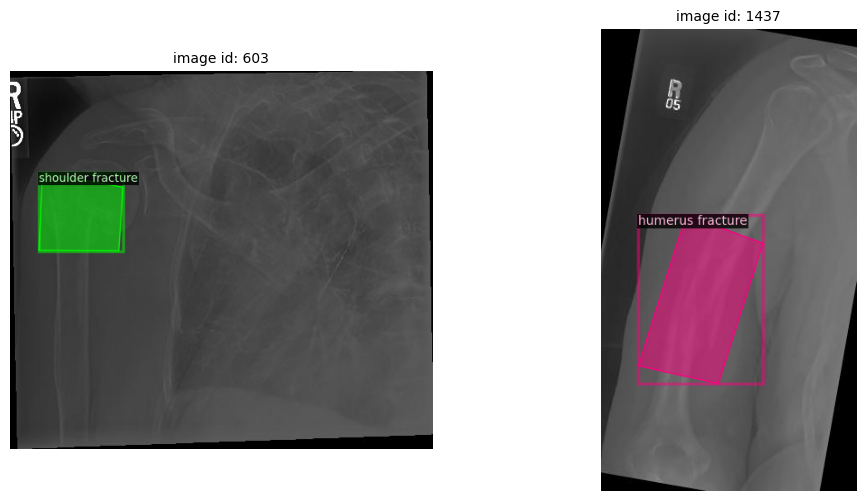

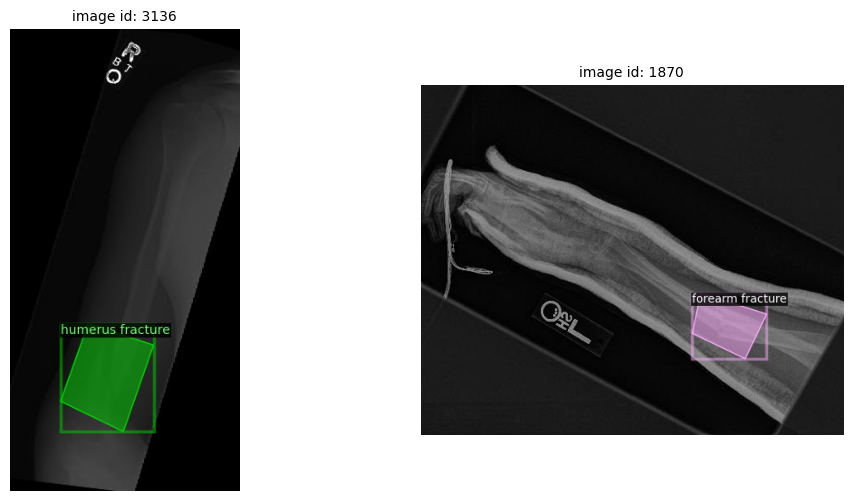

In [ ]:
# my_dataset_train_metadata = MetadataCatalog.get("bone_fractures_train")
# train_dataset_dicts = DatasetCatalog.get("bone_fractures_train")

create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 5 , image_scale = 1)
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 9 , image_scale = 1)

Faster R-CNN w/ResNeXt 101 FPN Model, Training

In [ ]:
from detectron2.engine import DefaultTrainer

EPOCHS = 250
NUM_CLASSES = 8
BASE_LR = 0.001

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("bone_fractures_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = EPOCHS
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# uncomment below to train
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/01 11:09:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:01, 212MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[03/01 11:09:46 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/01 11:10:30 d2.utils.events]:  eta: 0:07:40  iter: 19  total_loss: 2.161  loss_cls: 1.978  loss_box_reg: 0.02043  loss_rpn_cls: 0.2024  loss_rpn_loc: 0.01236    time: 2.0374  last_time: 1.8178  data_time: 0.0204  last_data_time: 0.0246   lr: 7.6924e-05  max_mem: 5913M
[03/01 11:11:13 d2.utils.events]:  eta: 0:06:45  iter: 39  total_loss: 0.4375  loss_cls: 0.1646  loss_box_reg: 0.0356  loss_rpn_cls: 0.1342  loss_rpn_loc: 0.01118    time: 1.9962  last_time: 1.8444  data_time: 0.0118  last_data_time: 0.0033   lr: 0.00015684  max_mem: 5913M
[03/01 11:11:53 d2.utils.events]:  eta: 0:06:06  iter: 59  total_loss: 0.2712  loss_cls: 0.1088  loss_box_reg: 0.05576  loss_rpn_cls: 0.05989  loss_rpn_loc: 0.01098    time: 2.0020  last_time: 2.1293  data_time: 0.0112  last_data_time: 0.0210   lr: 0.00023676  max_mem: 5913M
[03/01 11:12:35 d2.utils.events]:  eta: 0:05:40  iter: 79  total_loss: 0.2551  loss_cls: 0.1229  loss_box_reg: 0.06592  loss_rpn_cls: 0.04551  loss_rpn_loc: 0.00973    time: 2.0

In [ ]:
# Saving the model

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD
predictor = DefaultPredictor(cfg)

import pickle
with open("cfg.pkl", "wb") as f:
    pickle.dump(cfg, f)

Faster R-CNN w/ResNeXt 101 FPN Training Results

In [ ]:
# original code from https://eidos-ai.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e

def reading_metrics_from_json(metrics_path):
    metrics = []

    with open(metrics_path, 'r') as f:
        for line in f:
            metrics.append(json.loads(line))
    return metrics


def metric(metrics, specific_metric):
    metric = []
    for i in range(len(metrics)):
        try:
            metric.append(metrics[i][specific_metric])
        except KeyError:
            pass

    return metric

In [ ]:
train_metrics = reading_metrics_from_json('/kaggle/working/output/metrics.json')

total_loss = metric(train_metrics, 'total_loss')
cls_acc = metric(train_metrics, 'fast_rcnn/cls_accuracy')
false_neg = metric(train_metrics, 'fast_rcnn/false_negative')
loss_box_reg = metric(train_metrics, 'loss_box_reg')
iters = np.arange(1,EPOCHS,EPOCHS/len(total_loss))

In [ ]:
fig, axs = plt.subplots(1,4, figsize = (17, 4), dpi = 120)
fig.suptitle('Faster R-CNN w/ResNeXt 101 FPN', color = 'blue', fontsize=15,  style = "italic")

axs[0].grid(linestyle = 'dashdot')
axs[0].plot(iters, loss_box_reg)
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].set_title('Loss Box Regression', fontsize = 10)
tit0 = ' (the last value {0:.4f})'.format(loss_box_reg[-1])
axs[0].set_title('Loss Box Regression ' + tit0, fontsize = 10, color = 'red')

axs[1].grid(linestyle = 'dashdot')
axs[1].plot(iters, cls_acc)
axs[1].set_xlabel('epochs', fontsize = 10)
tit1 = ' (the last value {0:.3f})'.format(cls_acc[-1])
axs[1].set_title('Class Accuracy ' + tit1, fontsize = 10, color = 'red')

axs[2].grid(linestyle = 'dashdot')
axs[2].plot(iters, total_loss)
axs[2].set_xlabel('epochs', fontsize = 10)
tit2 = ' (the last value {0:.4f})'.format(total_loss[-1])
axs[2].set_title('Total Loss ' + tit2, fontsize = 10, color = 'red')

axs[3].grid(linestyle = 'dashdot')
axs[3].plot(iters, false_neg)
axs[3].set_xlabel('epochs', fontsize = 10)
axs[3].set_title('False Negative', fontsize = 10, color = 'red')

Faster R-CNN w/ResNeXt 101 FPN Test Results

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("bone_fractures_test", False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "bone_fractures_test")
inference_on_dataset(trainer.model, test_loader, evaluator)

Faster R-CNN w/ResNeXt 101 FPN Test Predictions

In [ ]:
my_dataset_test_metadata = MetadataCatalog.get("bone_fractures_test")
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("bone_fractures_test")


# A function for plotting an original image's bbox and predicted bbox
def create_predictions(dataset_dict, dataset_metadata, seed, image_scale = 0.8):
    np.random.seed(seed=seed)
    images = np.random.permutation(dataset_dict)[:3]

    fig, axs = plt.subplots(3,2, figsize = (10,15), dpi = 200)

    for i in range(3):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer1 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)

        vis_original = visualizer1.draw_dataset_dict(im)
        original_bbox = vis_original.get_image()

        visualizer2 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        outputs = predictor(img)
        out = visualizer2.draw_instance_predictions(outputs["instances"].to("cpu"))
        out_img = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
        final_bbox = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)

        axs[i][0].set_title('original bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][0].axis('off')
        axs[i][0].imshow(original_bbox)

        axs[i][1].set_title('predicted bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][1].axis('off')
        axs[i][1].imshow(final_bbox)

In [ ]:
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 3, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 93, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 643, image_scale=1)